### Planner Notebook

This notebook is my way of developing and testing the KML loading + route-finding, until it works well enough to write into a full program.

In [2]:
%load_ext autoreload
from pykml import parser
import geopandas as gpd
import shapely
import shapely.ops
from shapely import Point, LineString, Polygon
import osmnx as ox
import networkx as nx
import folium
import geopandas as gpd
import pyproj
from pyproj.database import query_utm_crs_info
from pyproj.aoi import AreaOfInterest
import matplotlib as mpl
import numpy as np



with open("wandrer-23-08-23.kml", "r") as f:
    root = parser.parse(f).getroot()

namespace = {"kml": 'http://www.opengis.net/kml/2.2'}
pms = root.xpath(".//kml:Placemark[.//kml:Polygon]", namespaces=namespace)
# for p in pms:
#   print(p.Polygon.outerBoundaryIs.LinearRing.coordinates)
print(pms[0])

In [3]:
num_linestrings = len(root.xpath(".//kml:Placemark[.//kml:LineString]", namespaces=namespace))
num_elements = root.getchildren()[0].countchildren()
print(f"File has {num_elements} elements and {num_linestrings} linestrings, leaving {num_elements - num_linestrings} other elements (I believe only region polygons)")


File has 89658 elements and 89530 linestrings, leaving 128 other elements (I believe only region polygons)


In [4]:
# Crunch those coordinate and coordinate systems
linestrings = root.xpath(".//kml:Placemark[.//kml:LineString]", namespaces=namespace)
global_crs = "WGS84"
global_geod = pyproj.Geod(ellps=global_crs)

linestrings = [ls for ls in linestrings if hasattr(ls, "LineString")]
# Use this dictionary method so an error is thrown if there's some key I haven't seen at the time of programming
travel_tags = {"#Traveled": True, "#TraveledUnpaved": True, "#Untraveled": False, "#UntraveledUnpaved": False}
linestrings_traveled = [travel_tags[ls.styleUrl] for ls in linestrings]
linestring_coordinate_texts = [ls.LineString.coordinates.text for ls in linestrings if hasattr(ls, "LineString")]
linestring_coords = [[tuple([float(c) for c in p.split(",")[:2]]) for p in ls.split(" ")] for ls in linestring_coordinate_texts]

In [5]:
# Go! 
nodes = {}
node_counter = 0
edge_counts = {}
edges = []

# Count up IDs for nodes and edges
for coords, traveled in zip(linestring_coords, linestrings_traveled):
    first, last = coords[0], coords[-1]
    for coord in (first, last):
        if coord not in nodes:
            nodes[coord] = node_counter
            node_counter += 1
    first_id, last_id = nodes[first], nodes[last]
    edge_count = edge_counts.get((first_id, last_id), 0)
    length = sum(global_geod.inv(*first, *second, radians=False)[2] for first, second in zip(coords[:-1], coords[1:]))
    edges.append((first_id, last_id, edge_count, length, traveled, shapely.LineString(coords)))
    edge_counts[(first_id, last_id)] = edge_count + 1

graph_nodes = gpd.GeoDataFrame([(value, key[0], key[1]) for key, value in nodes.items()], columns=["osmid", "x", "y"])
graph_nodes.set_index(["osmid"], inplace=True) # We fake the OSMID with a counter, but it still needs to be the key
graph_edges = gpd.GeoDataFrame(edges, columns=["u", "v", "key", "length", "traveled", "geometry"], crs=global_crs)
graph_edges.set_index(["u", "v", "key"], inplace=True)
del nodes
del edges
del edge_counts

In [6]:
# Find a UTM CRS that fits the data for a cartesian projection
# We'll need that projection to calculate heuristics using euclidean distance
aoi = AreaOfInterest(
        west_lon_degree=min(graph_nodes["x"]),
        south_lat_degree=min(graph_nodes["y"]),
        east_lon_degree=max(graph_nodes["x"]),
        north_lat_degree=max(graph_nodes["y"]),
    )

utm_crs = query_utm_crs_info(
    datum_name="WGS 84",
    area_of_interest=aoi,
)[0].code
transformer = pyproj.Transformer.from_crs(global_crs, utm_crs, always_xy=True)

graph_nodes["proj_pos"] = graph_nodes.apply(lambda row: np.array(transformer.transform(row["x"], row["y"], errcheck=True)[:2]), axis=1)

In [7]:
# Convert to osmnx (networkx, but geo) graph

crop_bbox = (39.7, 39.8, -105.15, -105.3)
graph = ox.graph_from_gdfs(graph_nodes, graph_edges)
import osmnx.truncate
graph = osmnx.truncate.truncate_graph_bbox(graph, *crop_bbox)
graph = nx.to_undirected(graph)

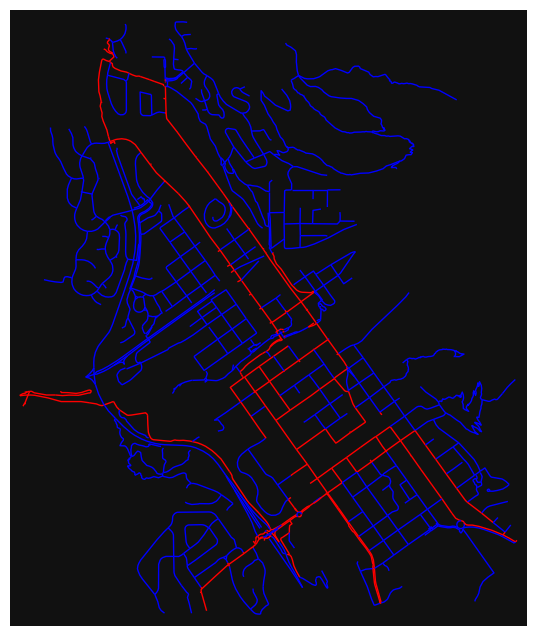

In [12]:
# preview the graph
# (this graph is of the Golden, Colorado area)
ec = ['r' if (a["traveled"]) else 'b' for u, v, k, a in graph.edges(data=True, keys=True)]
fig, ax = ox.plot_graph(graph, edge_color=ec, node_size=0)

In [9]:
list(graph.edges(data=True))[:10]

[(68686,
  68685,
  {'length': 9.280622942107032,
   'traveled': True,
   'geometry': <LINESTRING (-105.239 39.754, -105.239 39.754)>}),
 (5557,
  5556,
  {'length': 112.37274657264318,
   'traveled': False,
   'geometry': <LINESTRING (-105.219 39.761, -105.22 39.76)>}),
 (5557,
  5558,
  {'length': 80.56995287191108,
   'traveled': False,
   'geometry': <LINESTRING (-105.218 39.76, -105.219 39.761)>}),
 (5557,
  5567,
  {'length': 175.7690753966017,
   'traveled': False,
   'geometry': <LINESTRING (-105.217 39.762, -105.217 39.762, -105.218 39.761, -105.219 39....>}),
 (68504,
  5513,
  {'length': 16.529483621829606,
   'traveled': True,
   'geometry': <LINESTRING (-105.227 39.762, -105.227 39.762)>}),
 (68505,
  5513,
  {'length': 335.9390281195333,
   'traveled': True,
   'geometry': <LINESTRING (-105.229 39.764, -105.228 39.762, -105.227 39.762)>}),
 (68505,
  68506,
  {'length': 4.54715059170857,
   'traveled': True,
   'geometry': <LINESTRING (-105.229 39.764, -105.229 39.764)>})

In [10]:
# Yes I know its funny to go right back to a GeoDataFrame but I want to see what it looks like
from typing import cast


gdfs: gpd.GeoDataFrame = cast(gpd.GeoDataFrame, ox.graph_to_gdfs(graph, nodes=False))
gdfs["coords"] = gdfs.apply(lambda row: str(row["geometry"].coords[0]) +" -> " + str(row["geometry"].coords[-1]), axis=1)

start_coords = (-105.21939, 39.751545) # Expertly chosen by me
def find_nearest_node(node):
    # Yes its hideous but it was fast to write
    return min((((node[0]-graph.nodes[n]["x"])**2+(node[1]-graph.nodes[n]["y"])**2)**0.5, n) for n in graph.nodes())[1]
start_node: int = find_nearest_node(start_coords)
goal_node = start_node # Do a loop

def markered_map():
    m = gdfs.explore(column="traveled", cmap=["red", "blue"])
    points = [Point(graph.nodes[n]["x"], graph.nodes[n]["y"]) for n in (start_node, goal_node)]
    points_gdfs = gpd.GeoDataFrame(points, columns=["geometry"], crs=global_crs)
    points_gdfs.explore(m=m, marker_kwds=dict(radius=5, fill=True, color="green"))
    return m

markered_map()